In [92]:
from keras.layers import Input, Conv1D, Dense, Dropout, Multiply,ZeroPadding1D, Add, Activation,SimpleRNN
from keras.models import Model,Sequential

Data read with shape (101681, 555) and stored in variable df
Dataset organized by domain stored in variable df_domains.
Domain names: Index(['zh', 'fr', 'en', 'de', 'ru', 'nt', 'ja', 'es'], dtype='object')


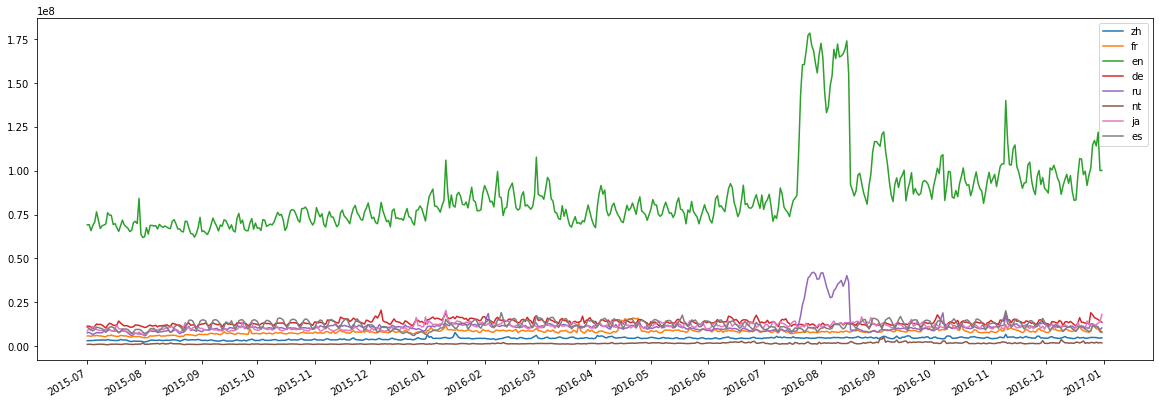

2015-07-01     69107851.0
2015-07-02     69189088.0
2015-07-03     65794463.0
2015-07-04     68719345.0
2015-07-05     70679925.0
                 ...     
2016-12-27    117210517.0
2016-12-28    114053513.0
2016-12-29    121915773.0
2016-12-30    100028604.0
2016-12-31    100158004.0
Freq: D, Name: en, Length: 550, dtype: float64

In [2]:
%run data_domains.ipynb
series = df_domains['en'].astype('float64').asfreq('d')
series

## Normalize

Normalizing the data is even more important when we're using deep neural networks. Data with high numbers can cause difficulties for the gradient descending.

In [80]:
def normalize_series(series):
    series_max  = series.max()
    series_min = series.min()
    series_normalized = (series-series_min)/(series_max-series_min)
    return series_normalized,series_max,series_min

def unnormalize_series(series,series_max,series_min):
    return series*(series_max-series_min)+series_min

This code shows that the data before normalizing and after un-normalize it is the same.

In [81]:
series_normalized,series_max,series_min= normalize_series(series)
series_unnormalized = unnormalize_series(series_normalized,series_max,series_min)

series.equals(series_unnormalized)

True

With the `Min-Max` scaler we have the data with values between $[0,1]$.

<AxesSubplot:>

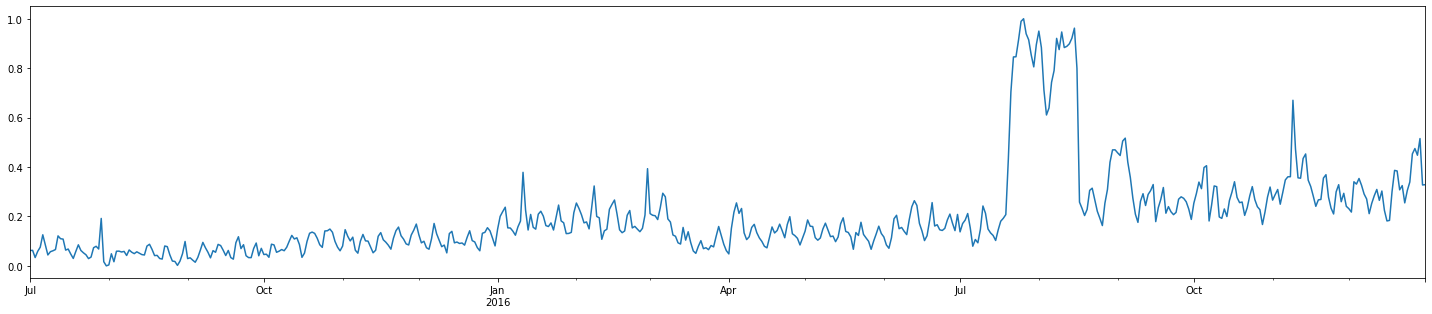

In [82]:
series_normalized.plot(figsize=(25,5))

This section can prepare and format the data for the time series prediction with keras models.
(Heavily inspired by Lab 8 of the class)

In [17]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)


def get_train_test_data(series, input_days,test_days, sample_gap=3):
    train = series[:-test_days] # training data is remaining days until amount of test_hours
    test = series[-test_days:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_days, sample_gap): 
        train_X.append(train[i:i+input_days]) # each training sample is of length input hours
        train_y.append(train[i+input_days]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_days] 
    test_y = test[input_days:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

We set the window size of the input and separate the training and testing set.

* `input_day` : Size of the window that is used as input for the model.
* `test_day` : Number of days for the testing set.

In [148]:
input_days = 30
test_days = 60
train_X, test_X_init, train_y, test_y = get_train_test_data(series_normalized, input_days,test_days, sample_gap=1)

print('- Shapes -')
print(f'Train X :{train_X.shape}')
print(f'Test X init :{test_X_init.shape}')
print(f'Train Y :{train_y.shape}')
print(f'Test Y :{test_y.shape}')


- Shapes -
Train X :(460, 30, 1)
Test X init :(30,)
Train Y :(460,)
Test Y :(30,)


Let's start with global parameters for the model. The dilation rates follow an exponential function. Here a lot of the parameters stay the same. If we want to change the number of filters of filter width, we could put them in a list and iterate over all the lists at the same time.

In [66]:
n_filters = 64
filter_width= 4
dilation_rates = [2**i for i in range(3)] #TODO: faire 2*int(np.log(len(series))) le int() maybe
dilation_rates

[1, 2, 4]

In [149]:
def wavenet_layer(n_filters,kernel_size,dilation_rate,name='wavenet'):
    def f(x):
        filter_out = Conv1D(filters=n_filters,kernel_size=filter_width,padding='valid',dilation_rate=dilation_rate,activation='tanh',use_bias=True,name=f'filter_{name}')(x)

        gate_out = Conv1D(filters=n_filters,kernel_size=filter_width,padding='valid',dilation_rate=dilation_rate,activation='sigmoid',use_bias=True,name=f'gate_{name}')(x)

        mult = Multiply(name=f'mult_{name}')([filter_out,gate_out])

        mult_padded = ZeroPadding1D((dilation_rate*(kernel_size-1),0))(mult)

        transformed = Conv1D(n_filters,1,padding='same',use_bias=True,name=f'trans_{name}')(mult_padded)
        
        skip_out = Conv1D(n_filters,1,padding='same',use_bias=True,activation='relu',name=f'skip_{name}')(mult_padded)

        return Add(name=f'resid_{name}')([transformed, x]), skip_out
    return f     


In [91]:
skip_connections = []

input_layer = Input(shape=(train_X.shape[1],1))

x = Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=1,activation='tanh',use_bias=True)(input_layer)

for dilation_rate in dilation_rates:
    x, skip_out = wavenet_layer(n_filters,kernel_size=filter_width,dilation_rate=dilation_rate,name=f'wavenet_{dilation_rate}')(x)
    skip_connections.append(skip_out)

x = Add()(skip_connections)

x = Activation('relu')(x)
x = Conv1D(filters=1,kernel_size=1,padding='same')(x)
x = Activation('relu')(x)
x = Conv1D(filters=1,kernel_size=1,padding='same')(x)

out_wavenet = Activation('relu')(x)

model = Model(input_layer,out_wavenet)

model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 30, 1)]      0           []                               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 30, 64)       320         ['input_23[0][0]']               
                                                                                                  
 filter_wavenet_1 (Conv1D)      (None, 27, 64)       16448       ['conv1d_40[0][0]']              
                                                                                                  
 gate_wavenet_1 (Conv1D)        (None, 27, 64)       16448       ['conv1d_40[0][0]']              
                                                                                            

Here are the compile and fitting processes of the model.

In [134]:
batch_size =32
epochs=350

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size)

Epoch 1/350
15/15 [==============================] - 2s 9ms/step - loss: 0.0485
Epoch 2/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0491
Epoch 3/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0489
Epoch 4/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0484
Epoch 5/350
15/15 [==============================] - 0s 11ms/step - loss: 0.0472
Epoch 6/350
15/15 [==============================] - 0s 11ms/step - loss: 0.0476
Epoch 7/350
15/15 [==============================] - 0s 11ms/step - loss: 0.0471
Epoch 8/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0472
Epoch 9/350
15/15 [==============================] - 0s 11ms/step - loss: 0.0468
Epoch 10/350
15/15 [==============================] - 0s 13ms/step - loss: 0.0472
Epoch 11/350
15/15 [==============================] - 0s 11ms/step - loss: 0.0469
Epoch 12/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0479
Epoch 13/350
15/15 [======

With the loss function we can see if the model is learning well through the epochs.

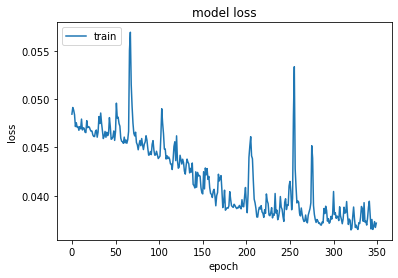

In [135]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

This function of prediction uses the result of the last prediction as input for the next prediction. (Inspired by Lab8 of the class).

In [118]:
def predict(model, X_init, n_steps):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.values.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:]
        X_init[:,-1,:] = pred
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

In [136]:
y_pred = predict(model, test_X_init, n_steps=len(test_y))

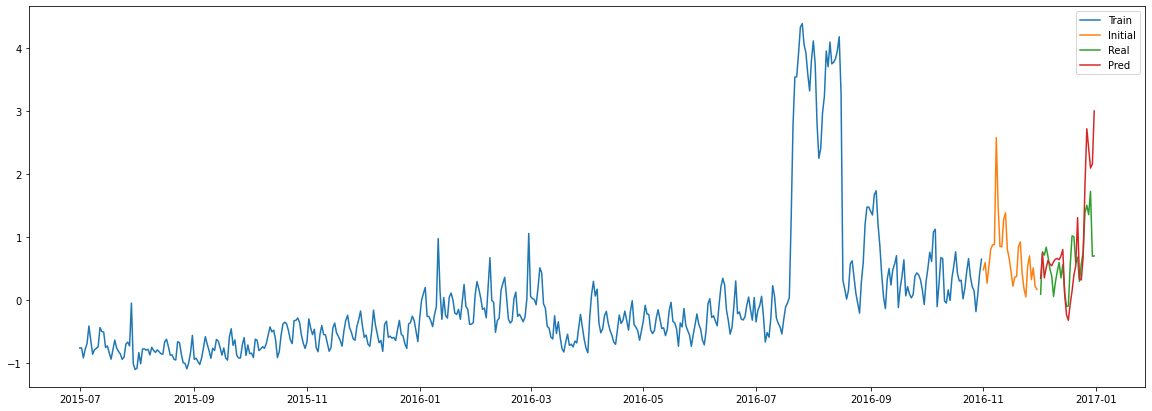

In [137]:
fig, ax = plt.subplots(figsize=(20,7))

train = np.concatenate((train_X[:-1,0],train_X[-1,:]))

ax.plot(series.index[:len(train)],train,label='Train')
ax.plot(series.index[len(train):len(train)+len(test_X_init)],test_X_init,label='Initial')
ax.plot(series.index[-len(test_y):],test_y,label='Real')
ax.plot(series.index[-len(test_y):],y_pred,label='Pred')

ax.legend()

plt.show()

Let's try with another series for prediction (here the Germany domain).

<AxesSubplot:>

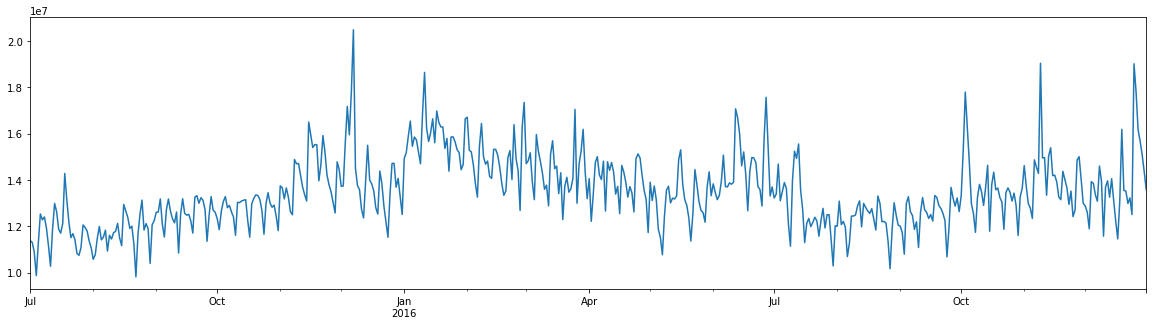

In [140]:
series = df_domains['de'].astype('float64').asfreq('d')
series.plot(figsize=(20,5))

In [141]:
series_normalized,series_max,series_min= normalize_series(series)
series_unnormalized = unnormalize_series(series_normalized,series_max,series_min)

series.equals(series_unnormalized)

True

In [150]:
start = 0
X_init = series_normalized[start:input_days+start]
y_real = series_normalized[input_days+start:]
y_pred = predict(model, X_init, n_steps=len(y_real))

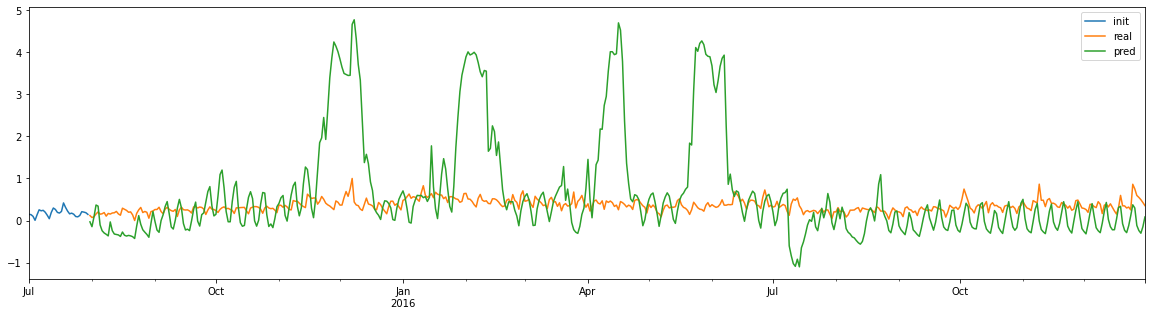

In [151]:
fig, ax = plt.subplots(figsize=(20,5))
X_init.plot(ax=ax,label='init')
y_real.plot(ax=ax,label='real')
ax.plot(y_real.index,y_pred,label='pred')

ax.legend()
plt.show()

With only the first input_size samples as initial X, we can see that we have very good predictions for all the end. The problem that we can see is that the model tries to simulate some jumps coming from the training set where there's a jump in summer 2016 (maybe caused by the Olympics).

So let's try to train our model with a complete series that is more stable like the spanish domain.

<AxesSubplot:>

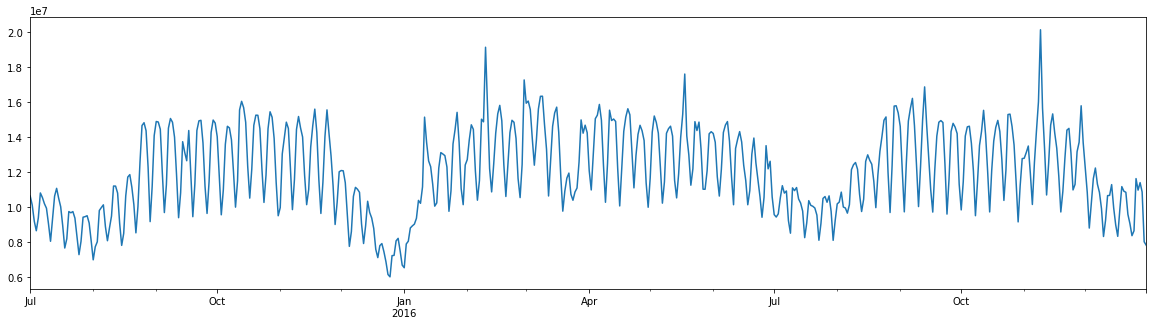

In [152]:
series = df_domains['es'].astype('float64').asfreq('d')
series.plot(figsize=(20,5))

In [153]:
series_normalized,series_max,series_min= normalize_series(series)
series_unnormalized = unnormalize_series(series_normalized,series_max,series_min)

series.equals(series_unnormalized)

True

In [154]:
input_days = 30
test_days = 60
train_X, test_X_init, train_y, test_y = get_train_test_data(series_normalized, input_days,test_days, sample_gap=1)

print('- Shapes -')
print(f'Train X :{train_X.shape}')
print(f'Test X init :{test_X_init.shape}')
print(f'Train Y :{train_y.shape}')
print(f'Test Y :{test_y.shape}')

- Shapes -
Train X :(460, 30, 1)
Test X init :(30,)
Train Y :(460,)
Test Y :(30,)


In [155]:
batch_size =32
epochs=350

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size)

Epoch 1/350
15/15 [==============================] - 2s 10ms/step - loss: 0.1150
Epoch 2/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0292
Epoch 3/350
15/15 [==============================] - 0s 11ms/step - loss: 0.0085
Epoch 4/350
15/15 [==============================] - 0s 11ms/step - loss: 0.0084
Epoch 5/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0081
Epoch 6/350
15/15 [==============================] - 0s 12ms/step - loss: 0.0077
Epoch 7/350
15/15 [==============================] - 0s 11ms/step - loss: 0.0071
Epoch 8/350
15/15 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 9/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0065
Epoch 10/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0063
Epoch 11/350
15/15 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 12/350
15/15 [==============================] - 0s 10ms/step - loss: 0.0061
Epoch 13/350
15/15 [======

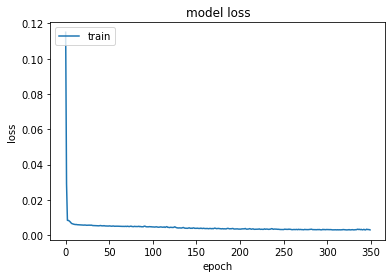

In [156]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
y_pred = predict(model, test_X_init, n_steps=len(test_y))

fig, ax = plt.subplots(figsize=(20,7))

train = np.concatenate((train_X[:-1,0],train_X[-1,:]))

ax.plot(series.index[:len(train)],train,label='Train')
ax.plot(series.index[len(train):len(train)+len(test_X_init)],test_X_init,label='Initial')
ax.plot(series.index[-len(test_y):],test_y,label='Real')
ax.plot(series.index[-len(test_y):],y_pred,label='Pred')

ax.legend()

plt.show()